In [85]:
import numpy as np
import pandas as pd
import pyaldata as pyal
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

from util import prep
from util import matlab_cca

In [86]:
# List of sessions
# sessions = ["M052_2025_01_23_15_15","M052_2025_01_24_15_00","M052_2025_01_25_14_30","M052_2025_01_27_15_00"]
# sessions = ["M051_2025_02_05_16_00","M051_2025_02_06_15_00","M051_2025_02_07_15_30","M051_2025_02_08_15_30","M051_2025_02_09_16_45","M051_2025_02_10_16_00","M051_2025_02_11_11_30","M051_2025_02_12_15_30","M051_2025_02_13_15_00","M051_2025_02_14_15_00"]
sessions = ["M056_2025_02_18_16_00","M056_2025_02_19_11_00","M056_2025_02_20_11_30","M056_2025_02_21_11_00"]

data_dir = 'C:/Users/Cecilia/data/raw'

# List to store logs for each session
session_logs = []

for session in sessions:
    animal = session[0:4]
    last_node = prep.load_BCI_log(data_dir + '/' + animal + '/' + session +  '/' + session + '_Process-get_last_node.log')
    middle_node = prep.load_BCI_log(data_dir + '/' + animal + '/' + session +  '/' + session + '_Process-get_middle_node1.log')
    save_node = prep.load_BCI_log(data_dir + '/' + animal + '/' + session +  '/' + session + '_Process-get_save_node.log')
    main = prep.load_BCI_log(data_dir + '/' + animal + '/' + session +  '/' + session + '_Process-Main.log')
    update_buffer = prep.load_BCI_log(data_dir + '/' + animal + '/' + session +  '/' + session + '_Process-update_buffer.log')
    update_pca = prep.load_BCI_log(data_dir + '/' + animal + '/' + session +  '/' + session + '_Process-update_pca.log')

    # Combine all DataFrames into one
    logs = pd.concat([last_node, middle_node, save_node, main, update_buffer, update_pca], ignore_index=True)
    logs = logs.sort_values(by='timestamp').reset_index(drop=True)
    #fix timestamp so that it starts with 0
    logs['timestamp'] = logs['timestamp'] - logs['timestamp'][0]   
    
    # Store the session name and logs in the list
    session_logs.append((session, logs))

# # Example usage: Access logs for each session
# for session, logs in session_logs:
#     print(f"Logs for {session}:")
#     display(logs)

In [87]:
cursor_all = []
cursor_avg_all = []
time_cursor_all = []
time_cursor_avg_all = []
bci_value_all = []
rewarded_bci_value_all = []
th_value_all = []
time_th_value_all = []
ccs_all = []
pca1_all = []
pca2_all = []

for session, logs in session_logs:

    filtered_log = logs[logs['message'].str.contains('rolling cca sum=')]
    cursor = filtered_log['message'].str.extract(r'rolling cca sum=([0-9\.]+)')
    cursor = pd.to_numeric(cursor[0], errors='coerce')
    time_cursor = np.array(filtered_log['timestamp'])
    
    
    filtered_log = logs[logs['message'].str.contains('rolling cca sum=', na=False)]
    ccs = filtered_log['message'].str.extract(r'\[([^\]]+)\]')[0]
    ccs = [np.array(row.split(), dtype=float) for row in ccs.dropna()] 
    ccs_num =10
    ccs = np.array([np.pad(arr, (0, ccs_num - len(arr)), mode='constant', constant_values=1)
                         if len(arr) < ccs_num else arr[:ccs_num] for arr in ccs])

    filtered_log = logs[logs['message'].str.contains(r'cursor value')]
    bci_change_value = filtered_log['message'].str.extract(r'(\d)$')
    bci_change_value = np.array(pd.to_numeric(bci_change_value[0], errors='coerce'))
    time_bci_change = filtered_log['timestamp']
    # Fix the bci values to be in each sample
    idx = np.searchsorted(time_bci_change, time_cursor, side='right') - 1 # Find indices of the most recent change
    bci_value = np.where(idx < 0, 1 - bci_change_value[0], bci_change_value[idx]) # If idx is -1 (before first change), set to the opposite of the first change

    filtered_log = logs[logs['message'].str.contains(r'Node2 PCA matrix/CCA threshold updated:')]
    th_change_value = filtered_log['message'].str.extract(r'new th=([0-9\.]+)')
    th_change_value = np.array(pd.to_numeric(th_change_value[0], errors='coerce'))
    time_th_change = filtered_log['timestamp']    
    # Fix the th values to be in each sample
    idx = np.searchsorted(time_th_change, time_cursor, side='right') - 1 # Find indices of the most recent change
    th_value = np.where(idx < 0, th_change_value[0], th_change_value[idx]) # If idx is -1 (before first change), set first th value

    window_size = 100
    cursor_avg = np.convolve(cursor, np.ones(window_size)/window_size, mode='valid')
    time_cursor_avg = time_cursor[int(window_size/2-1):int(len(time_cursor)-window_size/2)]

    # Rewarded intervals
    n_rewarded_samples = 5 # 200ms
    diff = np.diff(bci_value)
    start_indices = np.where(diff == 1)[0] + 1
    end_indices = np.where(diff == -1)[0] + 1
    if bci_value[0] == 1:
        start_indices = np.insert(start_indices, 0, 0)
    if bci_value[-1] == 1:
        end_indices = np.append(end_indices, len(bci_value))
    mask = np.zeros_like(bci_value, dtype=bool)
    for start, end in zip(start_indices, end_indices):
        if end - start >= n_rewarded_samples:
            mask[start:end] = True
    rewarded_bci_value = np.where(mask, bci_value, 0)
    
    filtered_log = logs[logs['message'].str.contains(r'pca1_matrix=')]
    pca1 = filtered_log['message'].str.extract(r'pca1_matrix=(\[\[.*?\]\])')[0]
    pca1 = [np.array(eval(row)) for row in pca1]
    
    filtered_log = logs[logs['message'].str.contains(r'pca2_matrix=')]
    pca2 = filtered_log['message'].str.extract(r'pca2_matrix=(\[\[.*?\]\])')[0]
    pca2 = [np.array(eval(row)) for row in pca2] 
    
    
    cursor_all.append(cursor)
    cursor_avg_all.append(cursor_avg)
    time_cursor_all.append(time_cursor)
    time_cursor_avg_all.append(time_cursor_avg)
    bci_value_all.append(bci_value)
    rewarded_bci_value_all.append(rewarded_bci_value)
    th_value_all.append(th_value)
    ccs_all.append(ccs)
    pca1_all.append(pca1)
    pca2_all.append(pca2)

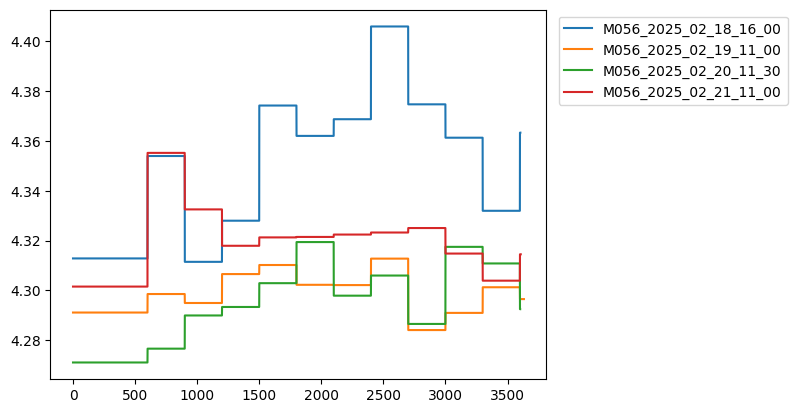

In [ ]:
for session in range(len(sessions)):
    t = time_cursor_all[session]-time_cursor_all[session][0] # so all thresholds start at 0
    plt.plot(t,th_value_all[session], label=sessions[session])
    plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
    
    # plt.ylim(4.2,5)

C:\Users\Cecilia\AppData\Local\Temp\ipykernel_2712\1488568411.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=session_labels, y=values, inner="box", palette="coolwarm")


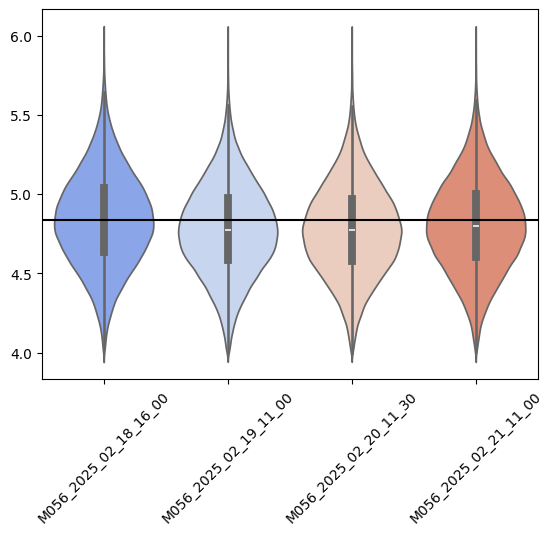

In [89]:
# Define filter range
lower_bound, upper_bound = 4, 6

filtered_cursor_all = [session[(session >= lower_bound) & (session <= upper_bound)] for session in cursor_all]
filtered_data = [(sessions[i], value) for i, session in enumerate(filtered_cursor_all) for value in session]

session_labels, values = zip(*filtered_data)

# Create a violin plot
# plt.figure(figsize=(10, 5))
sns.violinplot(x=session_labels, y=values, inner="box", palette="coolwarm")
plt.xticks(rotation=45)
plt.axhline(y=np.mean(cursor_all[0]),color='k')

plt.show()


In [90]:
np.sum((cursor_all[0]<4.3)) / cursor_all[0].shape[0]

0.03436677878051217

Text(0.5, 0, 'Cursor value')

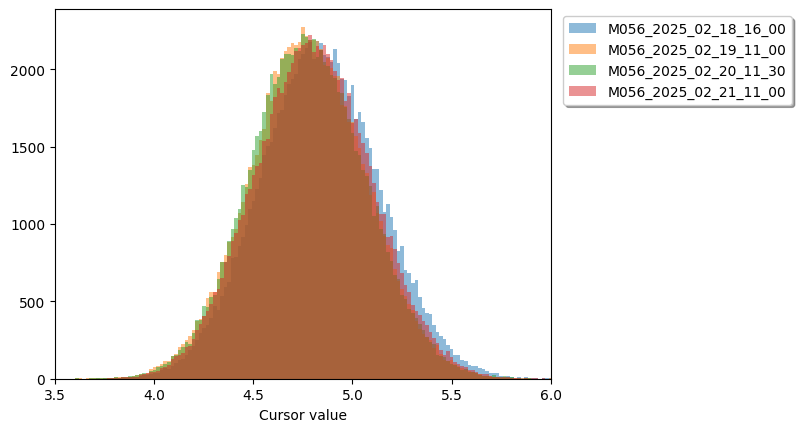

In [99]:
for session in range(len(sessions)):
    # if session <1:
    #     continue
    plt.hist(cursor_all[session], bins=505, alpha=0.5, label=sessions[session])
    plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right', shadow=True)
    
    plt.xlim(3.5,6)
# plt.hist(cursor_all[0], bins=505,alpha=0.5);
# plt.hist(cursor_all[1], bins=505,alpha=0.5);
# plt.hist(cursor_all[2], bins=505,alpha=0.5);
# # plt.plot(np.cumsum(cursor_all[0]))

# plt.axvline(x=4.3,color='k')
plt.xlabel('Cursor value')

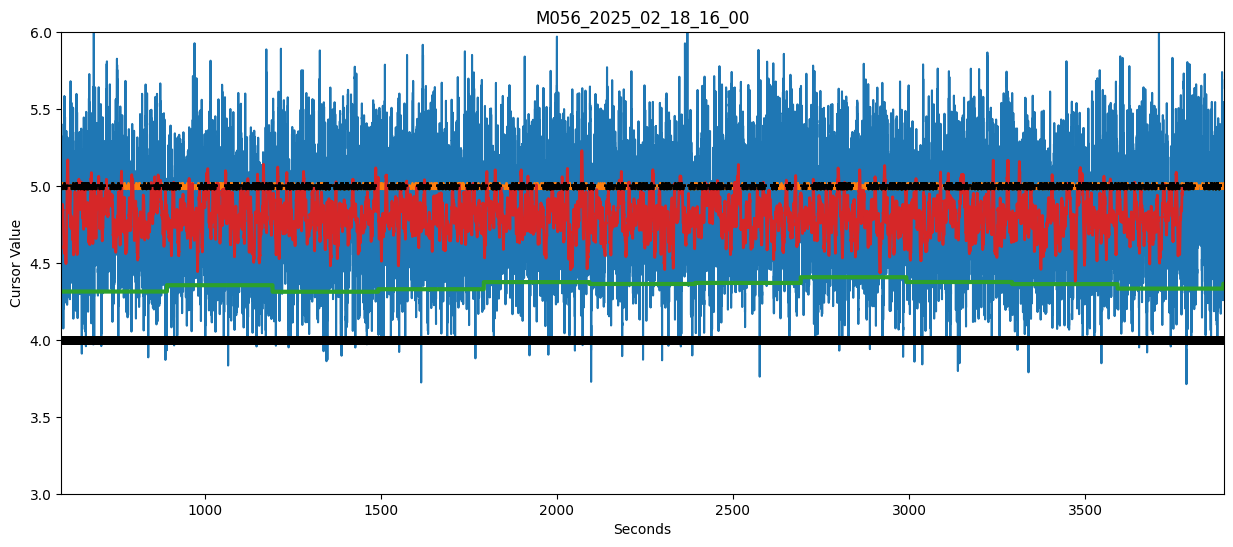

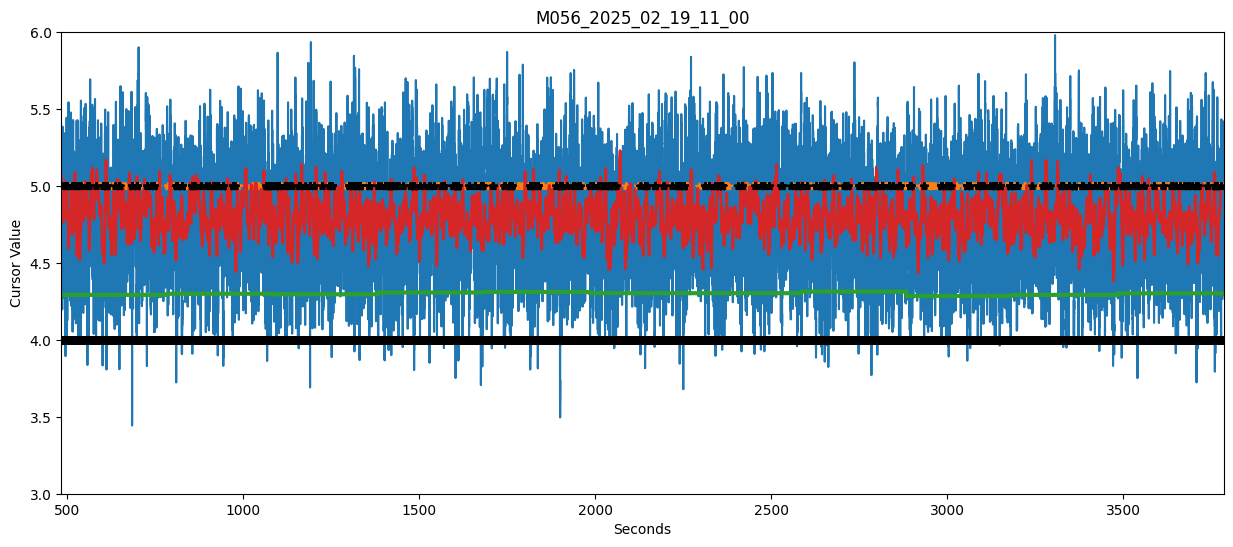

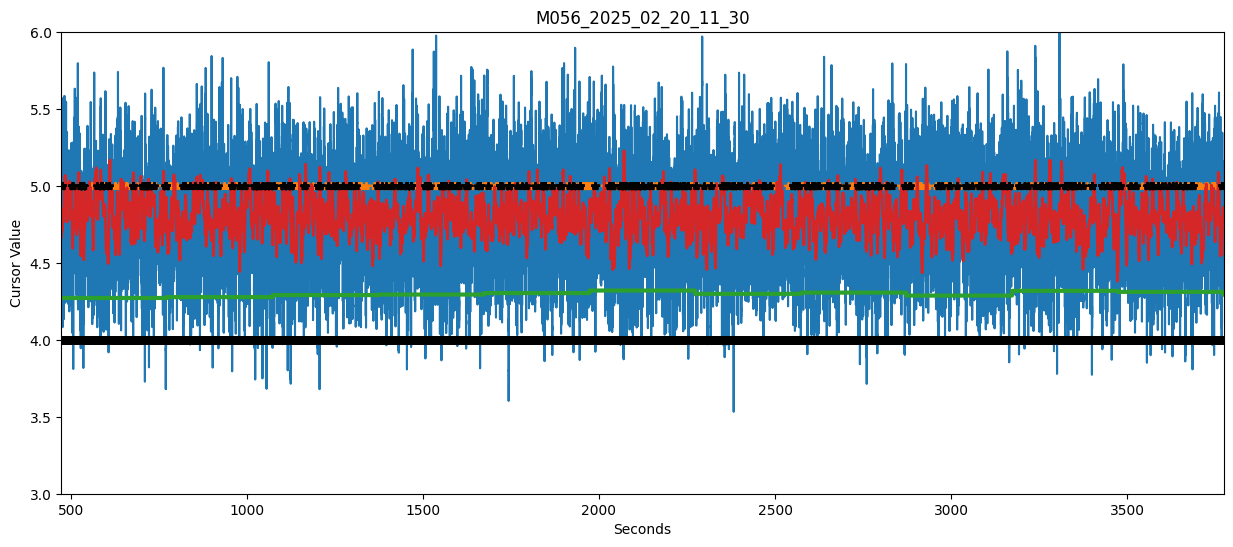

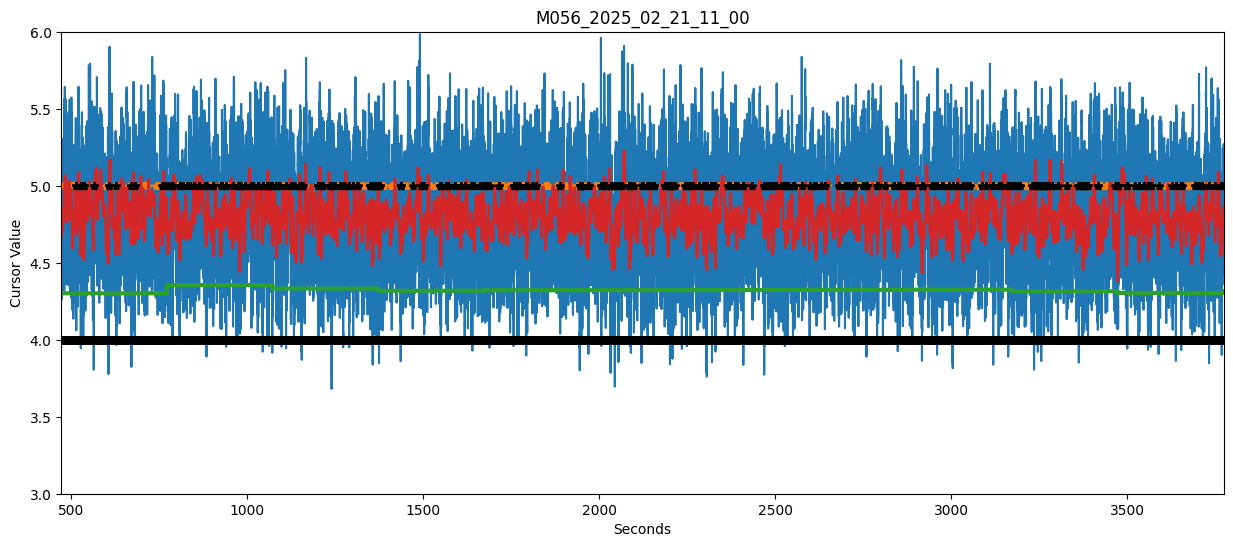

In [92]:
# Plot the cursor values
for session in range(len(session_logs)):
    min = time_cursor_all[session][0] + 300
    max = time_cursor_all[session][0] + 3601
    plt.figure(figsize=(15, 6))
    plt.plot(time_cursor_all[session], cursor_all[session])
    plt.plot(time_cursor_all[session], bci_value_all[session] + 4, '*')
    plt.plot(time_cursor_all[session], th_value_all[session], linewidth=3) 
    plt.plot(time_cursor_avg, cursor_avg, linewidth=2)
    plt.plot(time_cursor_all[session], rewarded_bci_value_all[session] + 4, 'k*')

    plt.title(session_logs[session][0])
    plt.xlabel('Seconds')
    plt.ylabel('Cursor Value')
    # Set x-axis limits
    plt.xlim(min, max)
    plt.ylim(3, 6)

    plt.show()

In [93]:
## ccs time change, individual session

# fig, ax = plt.subplots(len(session_logs), 1, figsize=(14, len(session_logs)*2))

# # Plot the cursor values
# for session in range(len(session_logs)):
#     min = time_cursor_all[session][0] + 300
#     max = time_cursor_all[session][0] + 3601
#     # ax[session].imshow(ccs_all[session].T, aspect='auto', cmap='viridis', interpolation='nearest')
#     im = ax[session].imshow(ccs_all[session].T, aspect='auto', cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
#     ax[session].set_title(session_logs[session][0])
#     fig.colorbar(im, ax=ax[session])

# # plt.ylabel('ccs')
# plt.tight_layout() 
# plt.show()

In [94]:
## weight matrix change, individual session

# fig, ax = plt.subplots(len(session_logs), 12, figsize=(20, len(session_logs)*2))

# # Plot the cursor values
# for session in range(len(session_logs)):
#     pca1 = pca1_all[session]
#     for i in range(len(pca1)):
#         im = ax[session,i].imshow(pca1[i], aspect='auto', cmap='viridis', interpolation='nearest', vmin=0, vmax=1)

#     # fig.colorbar(im, ax=ax[session])

# # plt.ylabel('ccs')
# plt.tight_layout() 
# plt.show()

In [95]:
ccs1_all = []
ccs2_all = []
# cca = CCA(n_components=10)
for session in range(len(session_logs)):
    pca1 = pca1_all[session]
    ccs1 = np.zeros([len(pca1),len(pca1)])
    pca2 = pca2_all[session]
    ccs2 = np.zeros([len(pca2),len(pca2)])
    for i in range(len(pca1)):
        for j in range(len(pca1)):
            # ccs[i,j] = np.mean(cca.fit(pca1[i],pca1[j]).coef_)
            A,B,r,U,V = matlab_cca.canoncorr(pca1[i], pca1[j], fullReturn = True)
            ccs1[i,j] = np.mean(r)
            
            A,B,r,U,V = matlab_cca.canoncorr(pca2[i], pca2[j], fullReturn = True)
            ccs2[i,j] = np.mean(r)
            
    ccs1_all.append(ccs1)
    ccs2_all.append(ccs2)

C:\Users\Cecilia\AppData\Local\Temp\ipykernel_2712\3169384882.py:8: UserWarning: Adding colorbar to a different Figure <Figure size 2000x2000 with 120 Axes> than <Figure size 1200x400 with 3 Axes> which fig.colorbar is called on.
  fig.colorbar(im, ax=ax[0])
C:\Users\Cecilia\AppData\Local\Temp\ipykernel_2712\3169384882.py:9: UserWarning: Adding colorbar to a different Figure <Figure size 2000x2000 with 120 Axes> than <Figure size 1200x400 with 4 Axes> which fig.colorbar is called on.
  fig.colorbar(im, ax=ax[1])
C:\Users\Cecilia\AppData\Local\Temp\ipykernel_2712\3169384882.py:8: UserWarning: Adding colorbar to a different Figure <Figure size 2000x2000 with 120 Axes> than <Figure size 1200x400 with 3 Axes> which fig.colorbar is called on.
  fig.colorbar(im, ax=ax[0])
C:\Users\Cecilia\AppData\Local\Temp\ipykernel_2712\3169384882.py:9: UserWarning: Adding colorbar to a different Figure <Figure size 2000x2000 with 120 Axes> than <Figure size 1200x400 with 4 Axes> which fig.colorbar is call

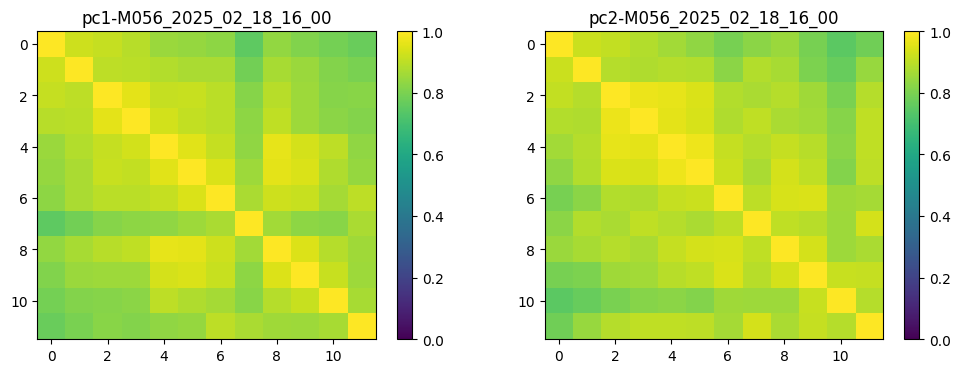

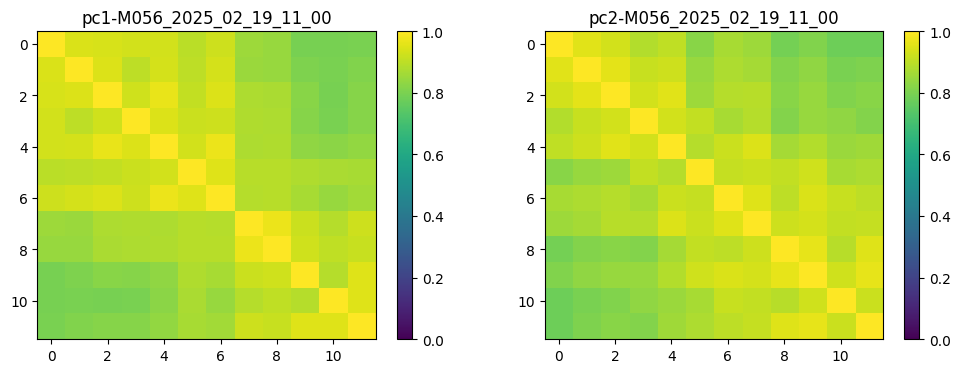

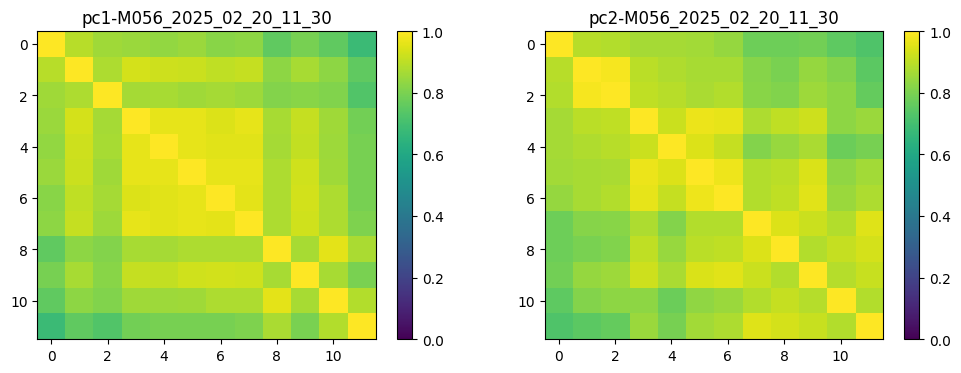

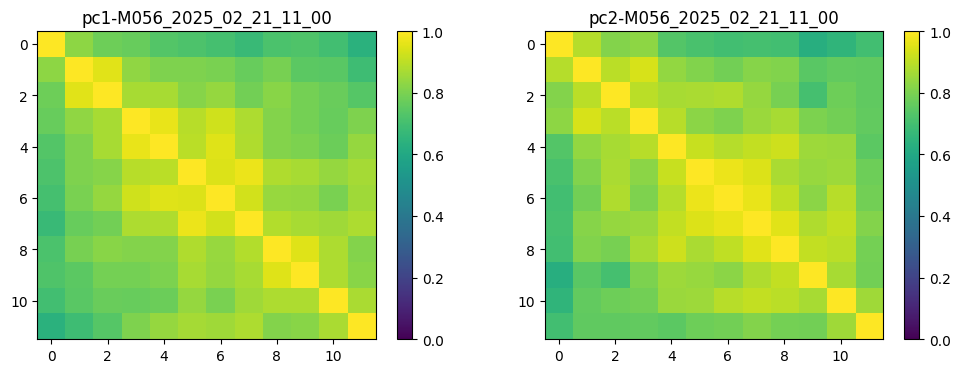

In [96]:
for session in range(len(session_logs)):     
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].imshow(ccs1_all[session], aspect='auto', cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
    ax[0].set_title("pc1-" + session_logs[session][0])
    ax[1].imshow(ccs2_all[session], aspect='auto', cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
    ax[1].set_title("pc2-" + session_logs[session][0])
    
    fig.colorbar(im, ax=ax[0])
    fig.colorbar(im, ax=ax[1])

C:\Users\Cecilia\AppData\Local\Temp\ipykernel_2712\2883211394.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


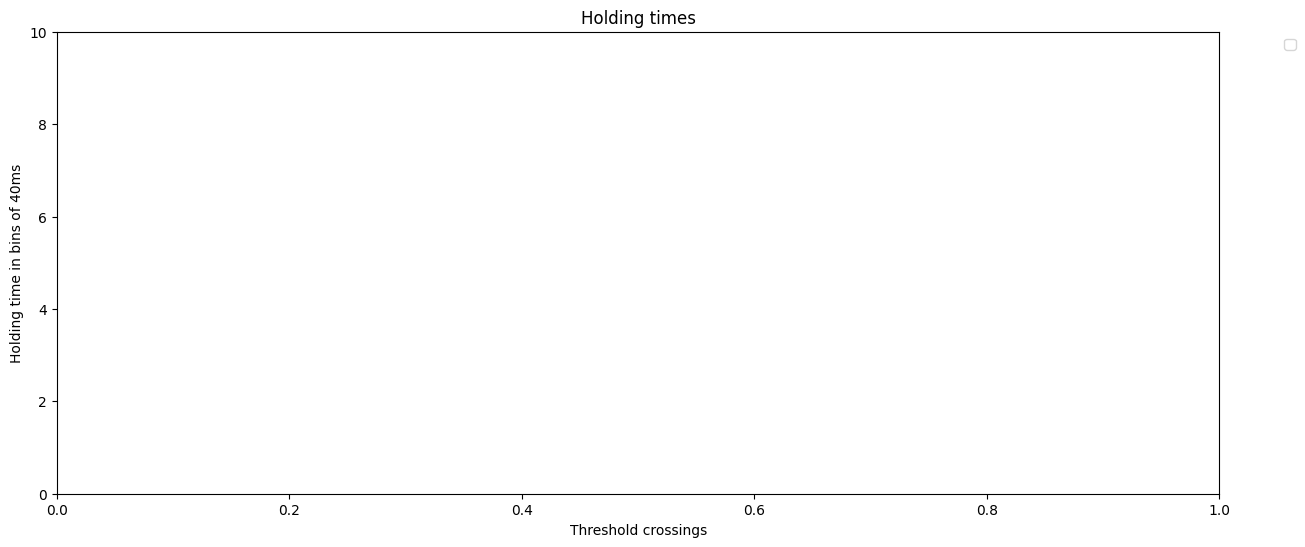

In [97]:
window_size = 20
plt.figure(figsize=(15, 6))
    
# Plot the cursor values
for session in range(len(session_logs)):
    if session < 6:
        continue
    bci_value = bci_value_all[session]

    # Find the start and end indices of groups of 1s
    diff = np.diff(bci_value)
    start_indices = np.where(diff == 1)[0] + 1
    end_indices = np.where(diff == -1)[0] + 1

    # Handle the case where the array starts or ends with a group of 1s
    if bci_value[0] == 1:
        start_indices = np.insert(start_indices, 0, 0)
    if bci_value[-1] == 1:
        end_indices = np.append(end_indices, len(bci_value))

    # Calculate the number of 1s in each group
    group_lengths = end_indices - start_indices

    # plt.plot(group_lengths, label = session_logs[session][0])
    plt.axhline(y=5, color='r', linestyle='--', linewidth=2)
    plt.plot(np.linspace(window_size/2, len(group_lengths)-window_size/2, len(group_lengths)-window_size+1),np.convolve(group_lengths, np.ones(window_size)/window_size, mode='valid'), label = session_logs[session][0])

plt.ylim(0,10)
plt.title('Holding times')
plt.xlabel('Threshold crossings')
plt.ylabel('Holding time in bins of 40ms')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Broken code

In [98]:
min = 300
max = 3601
y_reference = np.linspace(np.cumsum(rewarded_bci_value).min(), np.cumsum(rewarded_bci_value).max(), len(rewarded_bci_value)-7500)
plt.plot(time_bci_value,np.cumsum(rewarded_bci_value))
plt.plot(time_bci_value[7500:], y_reference, '--')
plt.xlim(min, max)

# y_reference = np.linspace(np.cumsum(bci_value).min(), np.cumsum(bci_value).max(), len(bci_value)-7500)
# plt.plot(time_bci_value,np.cumsum(bci_value))
# plt.plot(time_bci_value[7500:], y_reference, '--')
# plt.xlim(min, max)

plt.title('Cumulative sum of rewards')
plt.xlabel('Seconds')
plt.ylabel('Time bins holded (40ms time bins)')

NameError: name 'time_bci_value' is not defined

Text(0, 0.5, 'Threshold crossings')

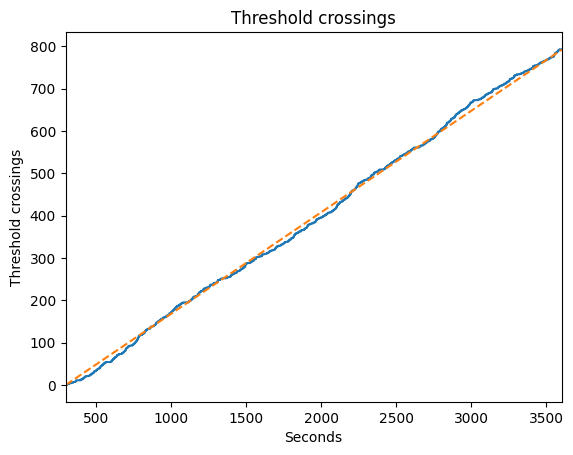

In [ ]:
min = 300
max = 3601

diff = np.diff(bci_value) > 0 # Changes from 0 to 1
y_reference = np.linspace(np.cumsum(diff).min(), np.cumsum(diff).max(), len(diff)-7500)

plt.plot(time_bci_value[:-1], np.cumsum(diff))
plt.plot(time_bci_value[7500:-1], y_reference, '--')
plt.xlim(min, max)
plt.title('Threshold crossings')
plt.xlabel('Seconds')
plt.ylabel('Threshold crossings')

Holding times!

Text(0, 0.5, 'Holding time in bins of 40ms')

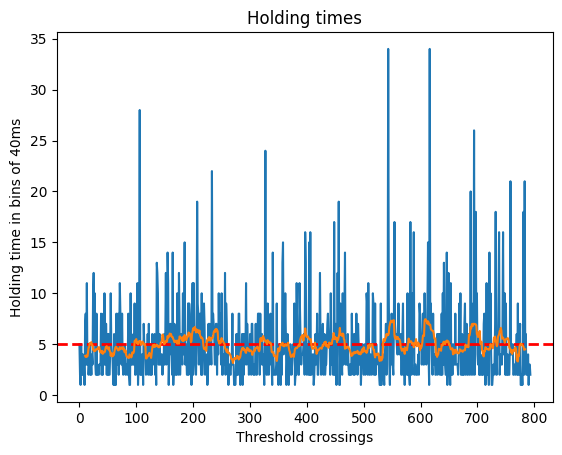

In [ ]:
# Find the start and end indices of groups of 1s
diff = np.diff(bci_value)
start_indices = np.where(diff == 1)[0] + 1
end_indices = np.where(diff == -1)[0] + 1

# Handle the case where the array starts or ends with a group of 1s
if bci_value[0] == 1:
    start_indices = np.insert(start_indices, 0, 0)
if bci_value[-1] == 1:
    end_indices = np.append(end_indices, len(bci_value))

# Calculate the number of 1s in each group
group_lengths = end_indices - start_indices


plt.plot(group_lengths)
plt.axhline(y=5, color='r', linestyle='--', linewidth=2)
window_size = 20
plt.plot(np.linspace(window_size/2, len(group_lengths)-window_size/2, len(group_lengths)-window_size+1),np.convolve(group_lengths, np.ones(window_size)/window_size, mode='valid'))

plt.title('Holding times')
plt.xlabel('Threshold crossings')
plt.ylabel('Holding time in bins of 40ms')


In [ ]:
len(group_lengths)-window_size/2

744.0

Compare first and second half of the recordings
